### Contractions using libraries
In this tutorial we will start revisiting the tensor contraction defined in the previous tutorial using tensor libraries
 
![reshape_permute](../pictures/exercice.png "from G. Evenbly")
![tensor order](../pictures/oredering_indices.png "from G. Evenbly")





Differently from the reference www.tensors.net we will use einsum, that can be used in future work with authomatic differentiation. In www.tensors.net there is a function called ncon you can learn how to use on your own. 
Here we will focus on einsum whose full documentation is here: https://numpy.org/doc/stable/reference/generated/numpy.einsum.html
Einsum is less intuitive in the sense that it copies the forumals using Einstein notation, rather than tensor networks drawing, though one can pass from one to the other decorating the drawing with indices. 
![reshape_permute](../pictures/contraction_indices.png "from G. Evenbly")
Let's start by defining the tensors as done in the previous class, aslo since here we are interested in optimizing the contraction also import the time package and the matplotlib to perform plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
d=10
A = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
B = np.random.rand(d,d,d,d)+1j*np.random.rand(d,d,d,d)
C = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
D = np.random.rand(d,d)+1j*np.random.rand(d,d)




We now retake the computation of the last class and check that the leading cost is actually $d^5$, we define the function contraction_by_hand, that take the five tensors and perform the contraction using only transpose and reshape as last time, 

In [2]:
def contraction_by_hand(A,B,C,D):
    d = A.shape[0]
    Cp = C.reshape(d,d*d)
    DC = (D@Cp).reshape(d,d,d)
# Then I contrac B with DC this has computational cost d^5
    Bp = B.reshape(d*d,d*d)
    DCp= DC.transpose(1,0,2).reshape(d*d,d)
    BDC = (Bp@DCp).reshape(d,d,d)
#At last I absorb A into the contraction with cost d^4
    BDCp = BDC.reshape(d,d*d)
    Ap=A.transpose(0,2,1)
    App=Ap.reshape(d*d,d)
    E=BDCp@App
    return E, DC,BDC

E = contraction_by_hand(A,B,C,D)

Now repeat the contraction for several d in the interval 2- collect the execution time and plot then in a log-log plot. (Why do we use a log-log plot?) On the x-axis put the bond dimension $d$ and on the y-axis put the execution time $t$.

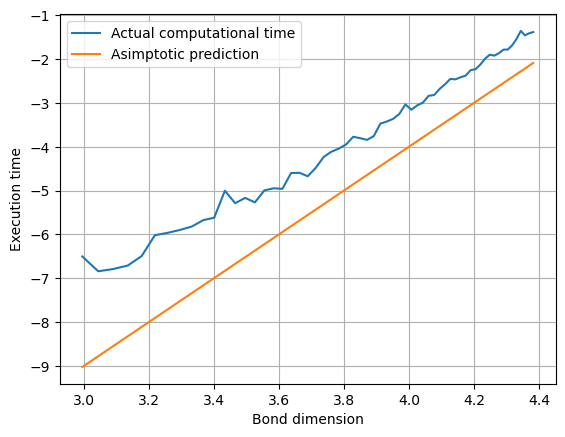

In [3]:
times_to_execute =[]
dmin=20
dmax=80
for d in range(dmin,dmax+1):
    A = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
    B = np.random.rand(d,d,d,d)+1j*np.random.rand(d,d,d,d)
    C = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
    D = np.random.rand(d,d)+1j*np.random.rand(d,d)
    t1 =time.time()
    E = contraction_by_hand(A,B,C,D)
    t2 =time.time()
    times_to_execute.append(t2-t1)
    
plt.plot(np.log(range(dmin,dmax+1)),np.log(times_to_execute),label ='Actual computational time')
plt.plot(np.log(np.linspace(dmin,dmax,dmax-dmin+1)),np.log(np.linspace(dmin,dmax,dmax-dmin+1)**5)-24, label ='Asimptotic prediction')      
plt.grid('on')
plt.xlabel('Bond dimension')
plt.ylabel('Execution time')
plt.legend()
plt.show()    



Now we define the same contraction but using einsum, use the manual page, and check that the result and scaling are the same than the contraction by hand (also check the intermediate steps.


In [51]:
d=10
A = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
B = np.random.rand(d,d,d,d)+1j*np.random.rand(d,d,d,d)
C = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
D = np.random.rand(d,d)+1j*np.random.rand(d,d)




def contraction_with_einsum(A,B,C,D):
    d = A.shape[0]
    DC =np.einsum('ef,fgd->egd',D,C)
# Then I contrac B with DC this has computational cost d^5
   
    BDC =np.einsum('acge,egd->acd',B,DC)
#At last I absorb A into the contraction with cost d^4
    E = np.einsum('acd,cbd->ab',BDC,A)
    return E, DC, BDC

E1,DC1,BDC1 = contraction_by_hand(A,B,C,D)
E2,DC2,BDC2 =contraction_with_einsum(A,B,C,D)

print('Difference in first partial contraction')
print(np.max(DC1-DC2))
print('Difference in second partial contraction')
print(np.max(BDC1-BDC2))
print('Difference in total contraction')

print(np.max(E1-E2))



Difference in first partial contraction
(1.3322676295501878e-15+8.881784197001252e-16j)
Difference in second partial contraction
(3.979039320256561e-13-2.842170943040401e-14j)
Difference in total contraction
(1.8189894035458565e-11-4.092726157978177e-12j)


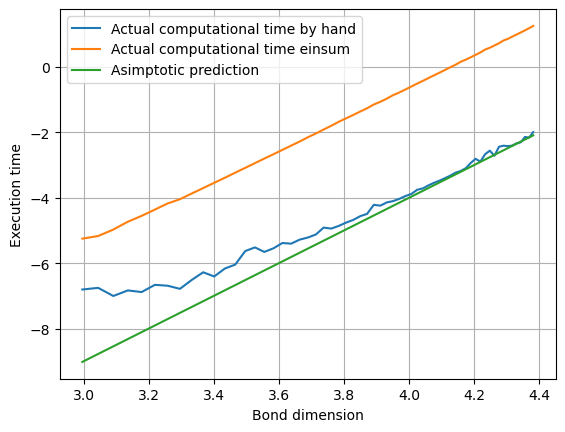

In [55]:
times_to_execute_ein =[]

for d in range(dmin,dmax+1):
    A = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
    B = np.random.rand(d,d,d,d)+1j*np.random.rand(d,d,d,d)
    C = np.random.rand(d,d,d)+1j*np.random.rand(d,d,d)
    D = np.random.rand(d,d)+1j*np.random.rand(d,d)
    t1 =time.time()
    E = contraction_with_einsum(A,B,C,D)
    t2 =time.time()
    times_to_execute_ein.append(t2-t1)
    
plt.plot(np.log(range(dmin,dmax+1)),np.log(times_to_execute),label ='Actual computational time by hand')
plt.plot(np.log(range(dmin,dmax+1)),np.log(times_to_execute_ein),label ='Actual computational time einsum')
plt.plot(np.log(np.linspace(dmin,dmax,dmax-dmin+1)),np.log(np.linspace(dmin,dmax,dmax-dmin+1)**5)-24, label ='Asimptotic prediction')      
plt.grid('on')
plt.xlabel('Bond dimension')
plt.ylabel('Execution time')
plt.legend()
plt.show()    


In [45]:
np.max(BDC1-BDC2)

(2.8421709430404007e-13+0j)